# Trilep analysis results

In this notebook we'll try to get the some idea about the final sensitivity of the trilep channel.


First, we import all the packages we need and load histograms from a cache.

In [1]:
%load_ext autoreload
%autoreload 2


import os

import numpy as np
import pandas as pd

from coffea import hist

from klepto.archives import dir_archive

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from plots.helpers import makePlot

ModuleNotFoundError: No module named 'plots'

In [2]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
#cache_name = 'trilep_analysis_SS_2tight'
cache_name = '0SFOS_neg'
cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

In [3]:
# redefine some labels and colors
my_labels = {
    'topW_v3': 'top-W scat.',
    'TTW': r'$t\bar{t}$W+jets',
    'TTX': r'$t\bar{t}$Z/H',
    'TTH': r'$t\bar{t}$H',
    'TTZ': r'$t\bar{t}$Z',
    'ttbar': r'$t\bar{t}$+jets',
    'DY': 'Drell-Yan',
    'diboson': 'VV/VVV',
    'rare': 'Rare',
    'MuonEG': 'Observed',
    'DoubleMuon': 'Observed',
    'EGamma': 'Observed',
    'pseudodata': 'Pseudo-data',
    'uncertainty': 'Uncertainty',
}

my_colors = {
    'topW_v3': '#FF595E',
    'TTW': '#8AC926',
    'TTX': '#FFCA3A',
    'TTZ': '#FFCA3A',
    'TTH': '#34623F',
    'DY': '#6A4C93',
    'ttbar': '#1982C4',
    'diboson': '#525B76',
    'rare': '#6A4C93',
    'MuonEG': '#000000',
    'DoubleMuon': '#000000',
    'EGamma': '#000000',
}

Data: 0 MC: 25.4


findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.


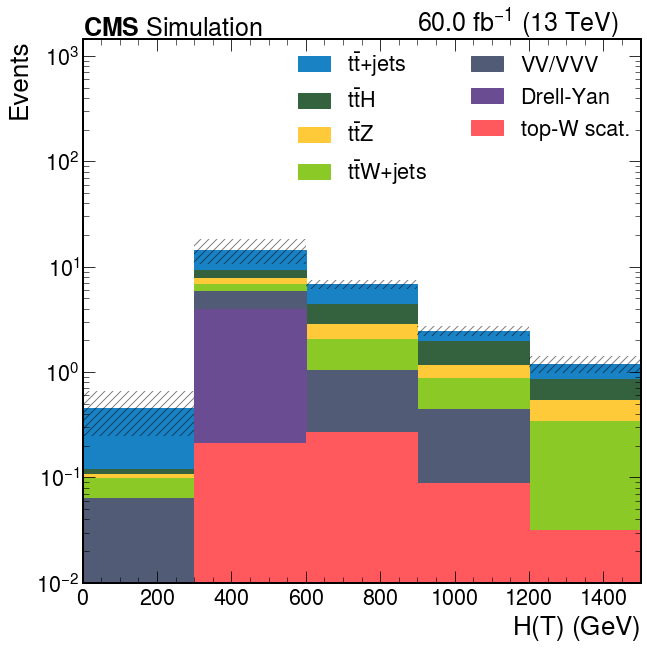

In [4]:
# check out that the histogram we want is actually there

mass_bins_coarse = hist.Bin('mass', r'$M\ (GeV)$', [0,100,150,200,400])
pt_bins_coarse = hist.Bin('pt', r'$p_{T}\ (GeV)$', [0,60,120,180,240])
ht_bins_coarse = hist.Bin("ht",        r"$H_{T}$ (GeV)", [0,300,600,900,1200])

makePlot(output, 'ST', 'ht',
         data=[],
         bins=ht_bins_coarse, log=True, normalize=False, axis_label=r'$H (T)$ (GeV)',
         new_colors=my_colors, new_labels=my_labels,
         order=['topW_v3', 'DY', 'diboson', 'TTW', 'TTZ', 'TTH', 'ttbar'],
         signals=[],
         omit=['EGamma', 'MuonEG', 'DoubleMuon', 'topW_EFT_cp8', 'topW_EFT_mix'],
         shape=False,
        )

# Limits

A few tools are in place that interface with the [combine tool](https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit), documentation can be found [here](http://cms-analysis.github.io/HiggsAnalysis-CombinedLimit/). The statistical backgrounds can be found in [this paper](https://cds.cern.ch/record/1379837?ln=en).


In [5]:
from Tools.dataCard import dataCard
from Tools.limits import makeCardFromHist

In order for this to run we first need to install the combine tool.

In your terminal on the uaf:
- navigate to your home directory
- make a new directory called "combine"

Then run the following commands:
```
cd combine
cmsrel CMSSW_10_2_13
cd CMSSW_10_2_13/src
cmsenv
git clone https://github.com/cms-analysis/HiggsAnalysis-CombinedLimit.git HiggsAnalysis/CombinedLimit
cd HiggsAnalysis/CombinedLimit
git fetch origin
git checkout v8.0.1
scramv1 b clean; scramv1 b # always make a clean build
```


In [6]:
card = dataCard(releaseLocation=os.path.expandvars('/home/users/$USER/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/'))

Before we can start, we need to get the histogram in the correct shape.
We want to:
- Remove real data entries
- Any signal processes we're not interested in right now, like topW_EFT_cp8 and topW_EFT_mix
- Group DY and diboson into a *rare* category, and keep all others
- Rebin the mass axis to something sensible, similar to what we've done above.

For removing datasets we don't want to look at we can use regular expressions (the *re* package)

In [7]:
import re

no_data_or_signal = re.compile('(?!(EGamma|DoubleMuon|MuonEG|topW_EFT_mix|topW_EFT_cp8))')

In [8]:
new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)

In [9]:
# check that all of this actually worked
new_hists['ST'].values()
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

The combine tool takes something called a data card as input. We have a function that turns our histogram in something the combine tool understands, `makeCardFromHist`.

In [10]:
sm_card_default_0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)

Writing cards using histogram: ST
Signal expectation:           0.60
Non-prompt background:        8.68
t(t)X(X)/rare background:     16.13
Observation:                  25.40
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/data/cards/ST_card.txt


In [11]:
# run a negative log-likelihood (NLL) scan for different signal strengths of our top-W scattering signal.
result = card.nllScan(sm_card_default_0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/hbronson/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/5bc50cca-b46d-4473-a200-eb1bc5611a91


We scan over 61 points for signal strengths *r* of 0 to 3. A signal strength of 0 corresponds to the non-existance of top-W scattering, 1 to the completely SM-like top-W scattering process, 2 to a top-W scattering process with 2x the cross section etc.

The results contain the negative log-likelihood ratio of the expected observation over our signal with *r*=0...3. The expected observation here corresponds to *r*=1.

Essentially, the likelihood ratio tells us which hypothesis of *r* best describes our observation. Because the expected observation has *r*=1, we should see a minimum of the negative log likelihood at *r*=1, while *r*=0 or *r*=3 are much less likely. Let's look at a plot.


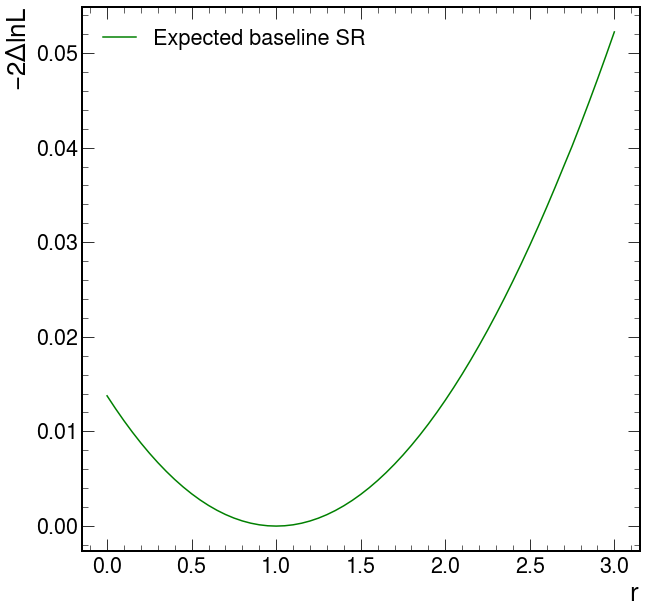

In [12]:
plt.figure()

plt.plot(result['r'][1:], result['deltaNLL'][1:]*2, label=r'Expected baseline SR', c='green')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [13]:
sm_card_no_syst_0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_no_syst',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

Writing cards using histogram: ST
Signal expectation:           0.60
Non-prompt background:        8.68
t(t)X(X)/rare background:     16.13
Observation:                  25.40
Adding  lumi = 1.03 for all bins and processes!
Done.

[cardFileWrite] Written card file /home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/data/cards/ST_no_syst_card.txt


In [14]:
result_no_syst = card.nllScan(sm_card_no_syst_0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

Creating /home/users/hbronson/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/d545c946-1ca0-41c8-b39b-c17f3096d86d


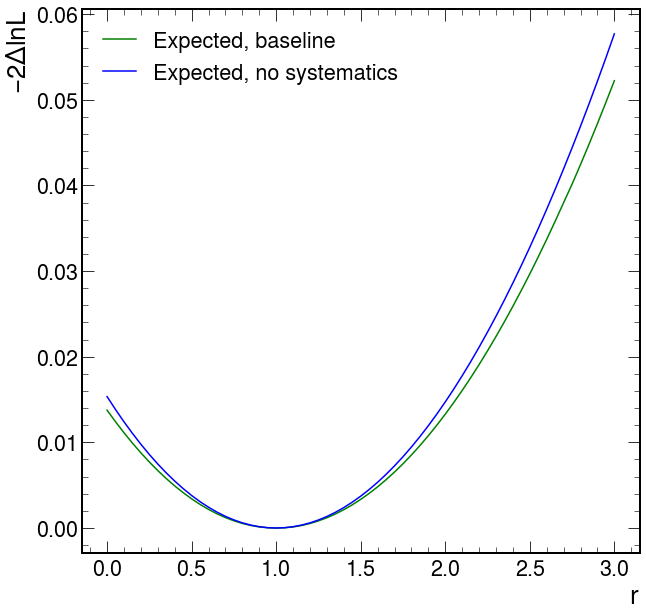

In [15]:
plt.figure()

plt.plot(result['r'][1:], result['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst['r'][1:], result_no_syst['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [16]:
card.cleanUp()

Deleting:  /home/users/hbronson/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit/2b38bc2d-a898-4f1e-8cd9-23d8af316e82


## Homework

I encourage you to look at the used functions to roughly understand what's happening under the hood! There are now wild card imports of any modules, so all functions should be easy to find.

More to-do's to be added.

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '2b_1SFOS_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_2b1SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_1',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)

result_2b1SFOS = card.nllScan(sm_card_default_2b1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_2b1SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_1',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_2b1SFOS = card.nllScan(sm_card_default_2b1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_2b1SFOS['r'][1:], result_2b1SFOS['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_2b1SFOS['r'][1:], result_no_syst_2b1SFOS['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '2b_0SFOS_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)


mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_2b0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_2',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)

result_2b0SFOS = card.nllScan(sm_card_default_2b0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_2b0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_2',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_2b0SFOS = card.nllScan(sm_card_default_2b1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_2b0SFOS['r'][1:], result_2b0SFOS['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_2b0SFOS['r'][1:], result_no_syst_2b0SFOS['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '1b_1SFOS_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_1b1SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_3',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)
result_1b1SFOS = card.nllScan(sm_card_default_1b1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')
sm_card_no_syst_1b1SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_3',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_1b1SFOS = card.nllScan(sm_card_default_1b1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_1b1SFOS['r'][1:], result_1b1SFOS['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_1b1SFOS['r'][1:], result_no_syst_1b1SFOS['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '1b_0SFOS_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_1b0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_4',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)
result_1b0SFOS = card.nllScan(sm_card_default_1b0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_1b0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_4',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_1b0SFOS = card.nllScan(sm_card_default_1b0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_1b0SFOS['r'][1:], result_1b0SFOS['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_1b0SFOS['r'][1:], result_no_syst_1b0SFOS['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '2b_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_2b = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_5',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)
result_2b = card.nllScan(sm_card_default_2b, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_2b = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_5',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_2b = card.nllScan(sm_card_default_2b, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_2b['r'][1:], result_2b['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_2b['r'][1:], result_no_syst_2b['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '1b_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_1b = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_6',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)
result_1b = card.nllScan(sm_card_default_1b, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_1b = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_6',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_1b = card.nllScan(sm_card_default_1b, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_1b['r'][1:], result_1b['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_1b['r'][1:], result_no_syst_1b['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '1SFOS_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_1SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_7',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)
result_1SFOS = card.nllScan(sm_card_default_1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_1SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_7',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_1SFOS = card.nllScan(sm_card_default_1SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_1SFOS['r'][1:], result_1SFOS['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_1SFOS['r'][1:], result_no_syst_1SFOS['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
# get one of our already existing caches
cache_dir = '/home/users/hbronson/tmp/tmp2/CMSSW_10_2_9/src/tW_scattering_dilep/caches/'
cache_name = '0SFOS_neg'

cache = dir_archive(cache_dir+cache_name, serialized=True)
cache.load()
output = cache.get('simple_output')

new_hists = {}

new_hists['ST'] = output['ST'][no_data_or_signal]
new_hists['ST'] = new_hists['ST'].rebin('ht', ht_bins_coarse)

mapping = {
    'rare': ['DY', 'diboson'],
    'TTW': ['TTW'],
    'TTZ': ['TTZ'],
    'TTH': ['TTH'],
    'ttbar': ['ttbar'],
    'topW_v3': ['topW_v3'],
}
new_hists['ST'] = new_hists['ST'].group("dataset", hist.Cat("dataset", "new grouped dataset"), mapping)
new_hists['ST'] = new_hists['ST'].project('ht', 'dataset')

sm_card_default_0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_8',
    systematics=True,
    categories=False,
    tw_name='topW_v3',
)
result_0SFOS = card.nllScan(sm_card_default_0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

sm_card_no_syst_0SFOS = makeCardFromHist(
    new_hists,
    'ST',
    overflow='all',
    ext='_8',
    systematics=False,
    categories=False,
    tw_name='topW_v3',
)

result_no_syst_0SFOS = card.nllScan(sm_card_default_0SFOS, rmin=0, rmax=3, npoints=61, options=' -v -1')

plt.figure()

plt.plot(result_0SFOS['r'][1:], result_0SFOS['deltaNLL'][1:]*2, label=r'Expected, baseline', c='green')
plt.plot(result_no_syst_0SFOS['r'][1:], result_no_syst_0SFOS['deltaNLL'][1:]*2, label=r'Expected, no systematics', c='blue')


plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()

In [ ]:
data_cards = {'card_1': sm_card_default_1b, 'card_2': sm_card_default_2b}

combined = card.combineCards(data_cards)
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')
plt.figure()

plt.plot(result_1b['r'][1:], result_1b['deltaNLL'][1:]*2, label=r'Expected, 1b', c='green')
plt.plot(result_2b['r'][1:], result_2b['deltaNLL'][1:]*2, label=r'Expected, 2b', c='blue')
plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()



In [ ]:
data_cards = {'card_1': sm_card_default_0SFOS, 'card_2': sm_card_default_1SFOS}

combined = card.combineCards(data_cards)
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')
plt.figure()

plt.plot(result_0SFOS['r'][1:], result_0SFOS['deltaNLL'][1:]*2, label=r'Expected, 0SFOS', c='green')
plt.plot(result_1SFOS['r'][1:], result_1SFOS['deltaNLL'][1:]*2, label=r'Expected, 1SFOS', c='blue')
plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()


In [ ]:
data_cards = {'card_1': sm_card_default_1b0SFOS, 'card_2': sm_card_default_2b0SFOS, 
              'card_3': sm_card_default_1b1SFOS, 'card_4': sm_card_default_2b1SFOS }

combined = card.combineCards(data_cards)
result_combined = card.nllScan(combined, rmin=0, rmax=3, npoints=61, options=' -v -1')
plt.figure()

plt.plot(result_1b0SFOS['r'][1:], result_1b0SFOS['deltaNLL'][1:]*2, label=r'Expected, 1b0SFOS', c='green')
plt.plot(result_2b0SFOS['r'][1:], result_2b0SFOS['deltaNLL'][1:]*2, label=r'Expected, 2b0SFOS', c='b')
plt.plot(result_1b1SFOS['r'][1:], result_1b1SFOS['deltaNLL'][1:]*2, label=r'Expected, 1b1SFOS', c='m')
plt.plot(result_2b1SFOS['r'][1:], result_2b1SFOS['deltaNLL'][1:]*2, label=r'Expected, 2b1SFOS', c='c')
plt.plot(result_combined['r'][1:], result_combined['deltaNLL'][1:]*2, label=r'Expected, combined', c='red')

plt.xlabel(r'$r$')
plt.ylabel(r'$-2\Delta  ln L$')
plt.legend()

plt.show()


In [ ]:
card.cleanUp()